In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import biodataplot.metaplot as bpm
from biodata.bigwig import BigWigIReader
from biodata.bed import BEDXReader
from genomictools import GenomicCollection

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import utils

In [3]:
import matplotlib
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [4]:
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Generate feature matrix

## Get bed files

In [5]:
inputfile = f"{PROJECT_DIR_o}ABC/K562/procap_genes.json"
with open(inputfile, "r") as f:
	 genes = json.load(f)

In [6]:
inputfile = f"{PROJECT_DIR_o}ABC/K562/GeneList.TSS1kb.bed"
df_genes = pd.read_table(inputfile, header=None)
df_genes.head(2)

0      1      2        3  4  5
0  chr1  35581  36581  FAM138F  0  -
1  chr1  35581  36581  FAM138A  0  -

In [7]:
for k in genes:
	outputfile = f"{PROJECT_DIR_o}ABC/K562/{k}_genes.bed"
	df2 = df_genes[df_genes[3].isin(genes[k])][[0,1,2]].drop_duplicates()
	df2.to_csv(outputfile, sep="\t", index=False, header=None)

## Get individual matrix

In [8]:
bws = {"DNase": f"{PROJECT_DIR_r}ENCODE/ENCFF414OGC.bigWig",
	   "H3K27ac": f"{PROJECT_DIR_r}ENCODE/ENCFF849TDM.bigWig"
	   }

In [9]:
ms = list(bws.keys())

In [10]:
# No flipping in this plot

df_features = {}
use_strand = False
for k in genes:
	bed = f"{PROJECT_DIR_o}ABC/K562/{k}_genes.bed"
	all_regions = BEDXReader.read_all(GenomicCollection, bed)
	for m in bws:
		index = [(r.chrom, r.chromStart, r.chromEnd) for r in all_regions]
		df_features[(m,k)] = pd.DataFrame(bpm.generate_signal_profile(all_regions, BigWigIReader(bws[m]), fixed_size=1001, use_strand=use_strand), index=index)

In [11]:
df_reformat = {}
for k in df_features:
	df = df_features[k].reset_index()
	df_reformat[k] = pd.melt(df,
						  id_vars="index",
						  value_vars=list(df.columns[1:]),
						  var_name="Position",
						  value_name="Feature"
						  )

## Combine dataframes for plotting

In [12]:
df_metaplots = {}
for m in ms:
	dfs = []
	for k in genes:
		df = df_reformat[(m,k)].copy()
		df["Label"] = k
		dfs.append(df)
	df_metaplots[m] = pd.concat(dfs).reset_index(drop=True)	

# Metaplots

## ylims

In [13]:
labels = list(genes.keys())
for m in ms:
	maxs = []
	mins = []
	df = df_metaplots[m]
	for label in labels:
		maxs.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().max())
		mins.append(df[df["Label"]==label].groupby("Position")["Feature"].mean().min())
	print(m, max(maxs), min(mins))

DNase 5.109838280411309 0.5991673005818798
H3K27ac 15.379929369499946 5.67631069602114


## Generate metaplots

In [14]:
def generate_metaplot(ms, ylims, yticks, outputfile, test, xlabel="Distance (kb)"):
	fig, axes = plt.subplots(1, len(ms), figsize=(6,2.5))
	labelpad = 2
	y_align = -0.15
	wspace = 0.35
	
	hue_order = ["Shared", "Divergent", "Unidirectional"]
	palette = ["#969696", "#313695", "#de77ae"]
	
	for m in ms:
		col = ms.index(m)
		ax = axes[col]
		utils.generate_feature_metaplot(df_metaplots[m], palette, hue_order, ax, test)
					
		ax.set_ylim(ylims[col])
		ax.set_yticks(yticks[col])
		ax.set_ylabel(m, fontsize=bfontsize, fontweight="bold")
		ax.get_yaxis().set_label_coords(y_align, 0.5)

		if col == 1:
			legend = ax.legend(loc="upper center", bbox_to_anchor=(-0.16, 1.32), 
					  ncol=len(hue_order), fontsize=sfontsize,
					  title="Promoters of genes regulated by", title_fontsize=sfontsize
					 )
			plt.setp(legend.get_title(), fontweight='bold')
		else:
			ax.legend([],[], frameon=False)

		xtick_list = [0,500,1000]
		xticklabel_list = ["-0.5", "0", "0.5"]
		ax.set_xlim([0, 1000])
		ax.set_xticks(xtick_list)
		ax.set_xticklabels(xticklabel_list)
		ax.set_xlabel(xlabel, fontsize=bfontsize, fontweight="bold")

		ax.tick_params(labelsize=sfontsize, pad=labelpad)

	fig.subplots_adjust(wspace=wspace)
	plt.savefig(outputfile, bbox_inches="tight", dpi=300) 

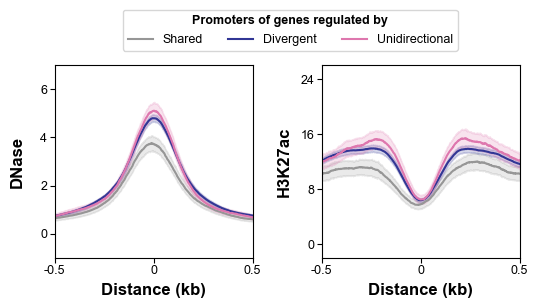

In [15]:
# test = True
test = False
ylims = [[-1, 7], [-2, 26]]
yticks = [[0, 2, 4, 6], [0, 8, 16, 24]]
outputfile = f"{PROJECT_DIR_o}supp_figures/SuppFig6f.pdf"
generate_metaplot(ms, ylims, yticks, outputfile, test)